In [1]:
from datetime import date
import ndjson
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.special import softmax
from tqdm import tqdm

plt.rcParams['font.size'] = 11
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = 'Arial'

In [19]:
import shutil
import matplotlib

shutil.rmtree(matplotlib.get_cachedir())

In [2]:
# Define a normalization function
def normalize_row(row):
    row_sum = row.sum()
    normalized_row = row / row_sum
    return normalized_row

mapping = {1: 'war and military in the Low Countries', 2: 'administration and local government', 3: 'weather and climate', 4: 'civic life',
                       5: 'life events and social interactions', 6: 'economic activities', 7: 'crime and justice', 8: 'international politics and diplomacy',
                        9: '(natural) disasters and damage', 10: 'public space, infrastructure and topography', 11: 'public celebrations and festivities',
                        12: 'history and dynasties', 13: 'local and regional politics and upheaval', 14: 'religion and church',
                        15: 'other languages and dialects', 16: 'patriotic sentiments'}

In [3]:
cat_names_original = ['war and military in the Low Countries', 'administration and local government', 'weather and climate', 'civic life',
                     'life events and social interactions', 'economic activities', 'crime and justice', 'international politics and diplomacy',
                      '(natural) disasters and damage', 'public space, infrastructure and topography', 'public celebrations and festivities',
                    'history and dynasties', 'local and regional politics and upheaval', 'religion and church', 
                    'other languages and dialects', 'patriotic sentiments']

In [4]:
df = pd.read_csv('../models/230807/230807_topic_words_theme_2.csv', sep=',', index_col=0)

with open('../models/230807/primitive_topic_top5.ndjson') as fin:
	primtop = ndjson.load(fin)

primtop = pd.DataFrame(primtop)

for i in range(0,5):
    primtop = primtop.merge(df[['topic', 'category']], left_on=f'topic_id_{i}', right_on='topic').sort_values('clean_month').drop('topic', axis=1).rename(columns={'category': f'category_{i}'})

In [5]:
all_rows = []

for i, r in tqdm(primtop.iterrows(), total=primtop.shape[0]):
    d_row = dict(r)
    try:
        d_row['clean_month_dt'] = date.fromisoformat(d_row['clean_month'])
        all_rows.append(d_row)
    except ValueError:
        continue

primtop = pd.DataFrame(all_rows)
primtop.shape

100%|██████████| 84583/84583 [00:12<00:00, 6784.54it/s]


(84548, 19)

In [6]:
with open('../models/230807/cossims_corrected.ndjson') as fin:
	cossims = ndjson.load(fin)

data_df = []
for item in tqdm(cossims, total=len(cossims)):
    try:
        item['clean_month_dt'] = date.fromisoformat(item['clean_month'])
        data_df.append(item)
    except ValueError:
        continue

cosdf = pd.DataFrame(data_df)

100%|██████████| 84583/84583 [00:01<00:00, 65988.59it/s]


In [7]:
cosdf_softmax = cosdf.iloc[:, 3:439].apply(softmax, axis=1)
cosdf_softmax = pd.merge(cosdf[['doc_id', 'clean_month', 'call_nr_clean']], cosdf_softmax, left_index=True, right_index=True)

## Topic variation per author

### With full distribution

In [8]:
# Create an empty dictionary
category_dict = {}

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    category = row['category']
    topic = row['topic']
    
    # Check if the category already exists in the dictionary
    if category in category_dict:
        # Append the topic number to the existing list of topics for the category
        category_dict[category].append(topic)
    else:
        # Create a new list of topics for the category
        category_dict[category] = [topic]

In [9]:
df_cat_softmax = pd.DataFrame()

for category, topics in category_dict.items():
    topics_str = [str(topic) for topic in topics]
    df_cat_softmax[category] = cosdf_softmax[topics_str].sum(axis=1)

df_cat_softmax = pd.merge(cosdf[['doc_id', 'clean_month', 'call_nr_clean']], df_cat_softmax, left_index=True, right_index=True)
authors_cat = df_cat_softmax.groupby('call_nr_clean')[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16].sum()
authors_cat = authors_cat.apply(normalize_row, axis=1)

/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_12822/2354593883.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  authors_cat = df_cat_softmax.groupby('call_nr_clean')[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16].sum()


### With three most similar categories of each primitive

In [10]:
authors_cat1 = primtop.groupby(['call_nr_clean', 'category_0'])['category_0'].count().unstack().fillna(0)
authors_cat2 = authors_cat1.apply(normalize_row, axis=1)

In [11]:
zero_counts = (authors_cat2 == 0).sum(axis=1)
authors_cat3 = authors_cat2[zero_counts <= 12]

authors_cat3.shape

(118, 16)

In [12]:
# Grouping and counting for each category column separately
category_0_counts = primtop.groupby(['call_nr_clean', 'category_0'])['category_0'].count().unstack().fillna(0)
category_1_counts = primtop.groupby(['call_nr_clean', 'category_1'])['category_1'].count().unstack().fillna(0)
category_2_counts = primtop.groupby(['call_nr_clean', 'category_2'])['category_2'].count().unstack().fillna(0)

# Summing the results across the three category DataFrames
summed_counts = category_0_counts.add(category_1_counts, fill_value=0).add(category_2_counts, fill_value=0)


In [13]:
summed_counts2 = summed_counts.apply(normalize_row, axis=1)

### Find coefficient of variation in topic categories

In [13]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x)

result_cv = pd.DataFrame(summed_counts.T.apply(cv).sort_values(ascending=True), columns=['cv']).reset_index()
#result_cv = pd.DataFrame(authors_cat2.T.apply(cv).sort_values(ascending=True), columns=['cv']).reset_index()

In [15]:
result_cv['year'] = result_cv['call_nr_clean'].str[:4]
result_cv['year'] = result_cv['year'].astype(int)

In [16]:
result_cv.to_csv('../output/primitives_230807/result_cv_topics_absolute.csv')

In [63]:
cat_topics = (summed_counts != 0).sum(axis=1)
cat_topics = pd.DataFrame(cat_topics, columns=['nr_topics']).reset_index()
cat_topics['year'] = cat_topics['call_nr_clean'].str[:4]
cat_topics['year'] = cat_topics['year'].astype(int)

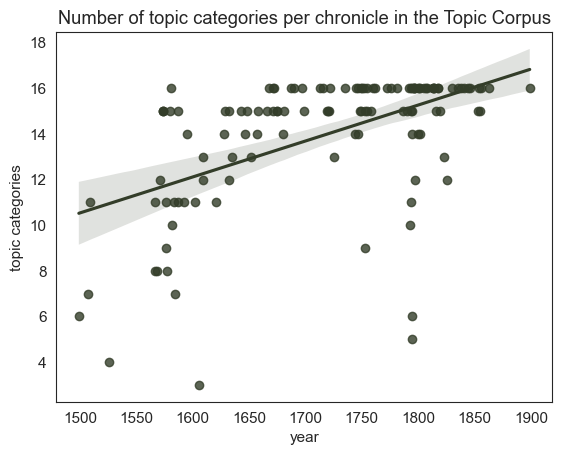

In [66]:
fig, axs = plt.subplots()

sns.regplot(x='year', y='nr_topics', data=cat_topics, marker='o', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
axs.set_title('Number of topic categories per chronicle in the Topic Corpus')
axs.set_ylabel('topic categories')
axs.set_xlabel('year')

fig.savefig('../images/nr_topics.pdf', bbox_inches='tight')

#### Coefficient of variation

In [14]:
result_cv = pd.read_csv('../output/primitives_230807/result_cv_topics_absolute.csv', sep=';', index_col=0)
result_cv.head()

,call_nr_clean,cv,year,nz,cp,hub
122,1499_Rott_Jans,3.220547,1499,n,c,i
124,1507_Beek_Trec,3.588256,1507,n,p,o
88,1509_Zier_Anon,1.823340,1509,n,p,o
125,1526_Zwol_Stee,3.680673,1526,n,p,o
98,1567_Amst_Bies,1.982280,1567,n,c,i


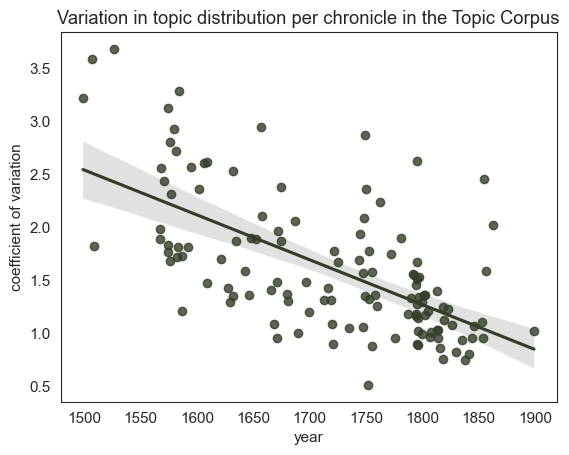

In [69]:
fig, axs = plt.subplots()

sns.regplot(x='year', y='cv', data=result_cv, marker='o', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
axs.set_title('Variation in topic distribution per chronicle in the Topic Corpus')
axs.set_ylabel('coefficient of variation')
axs.set_xlabel('year')

fig.savefig('../images/cv_chronicle.pdf', bbox_inches='tight')

### CV in Northern versus Southern Netherlands

In [70]:
result_cv_n = result_cv[result_cv['nz'] == 'n']
result_cv_z = result_cv[result_cv['nz'] == 'z']
print(result_cv_n.shape)
print(result_cv_z.shape)

(88, 5)
(38, 5)


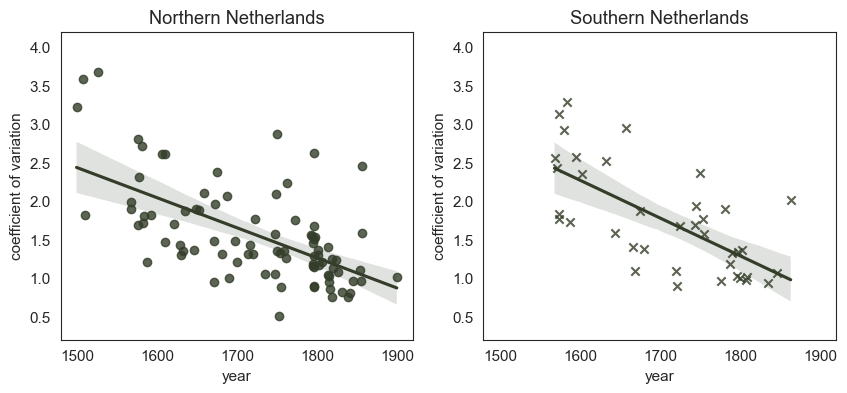

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharex=True)

sns.regplot(ax=axs[0], x='year', y='cv', data=result_cv_n, marker='o', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
sns.regplot(ax=axs[1], x='year', y='cv', data=result_cv_z, marker='x', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
axs[0].set_title('Northern Netherlands')
axs[1].set_title('Southern Netherlands')
axs[0].set_ylim(0.2,4.2)
axs[1].set_ylim(0.2,4.2)
axs[0].set_ylabel('coefficient of variation')
axs[1].set_ylabel('coefficient of variation')
axs[0].set_xlabel('year')
axs[0].set_xlabel('year')

fig.savefig('../images/cv_chronicle_nz.pdf', bbox_inches='tight')

### CV in centre versus periphery

In [15]:
result_cv_c = result_cv[result_cv['hub'] == 'i']
result_cv_p = result_cv[result_cv['hub'] == 'o']
print(result_cv_c.shape)
print(result_cv_p.shape)

(62, 6)
(64, 6)


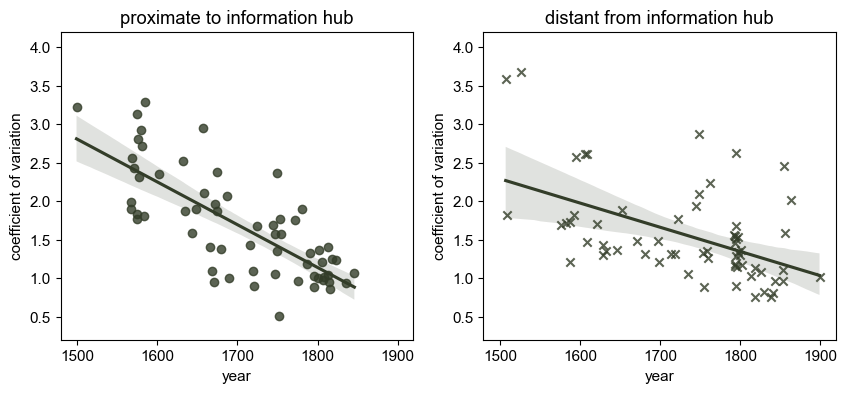

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharex=True)

sns.regplot(ax=axs[0], x='year', y='cv', data=result_cv_c, marker='o', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
sns.regplot(ax=axs[1], x='year', y='cv', data=result_cv_p, marker='x', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
axs[0].set_title('proximate to information hub')
axs[1].set_title('distant from information hub')
axs[0].set_ylim(0.2,4.2)
axs[1].set_ylim(0.2,4.2)
axs[0].set_ylabel('coefficient of variation')
axs[1].set_ylabel('coefficient of variation')
axs[0].set_xlabel('year')
axs[0].set_xlabel('year')

fig.savefig('../images/cv_chronicle_cp.pdf', bbox_inches='tight')

### Find max values (normalized)

In [17]:
result_dfs = []
for index, row in authors_cat3.iterrows():
    max_value = row.max()

    result_dfs.append(pd.DataFrame({'index': [index], 'max_value': [max_value]}))

result_df = pd.concat(result_dfs, ignore_index=True)
result_df

,index,max_value
0,1509_Zier_Anon,0.478261
1,1567_Amst_Bies,0.447761
2,1567_Amst_Reae,0.857143
3,1568_Gent_Vaer,0.847727
4,1571_Gent_Camp,0.876330
...,...,...
113,1854_Tilb_Beer,0.339237
114,1855_Popp_Jong,0.694407
115,1856_Wird_Hell,0.281744
116,1863_Izeg_Tang,0.752727


In [18]:
result_cv = result_cv.sort_values(by='cv')

In [19]:
#authors_cat3 = authors_cat3.reindex(result_cv['call_nr_clean'])
#authors_cat2 = authors_cat2.reindex(result_cv['call_nr_clean'])
summed_counts2 = summed_counts2.reindex(result_cv['call_nr_clean'])

### Average topic distribution in Northern versus Southern Netherlands

In [20]:
#topics_nz = authors_cat2.merge(result_cv[['call_nr_clean', 'nz']], left_on='call_nr_clean', right_on='call_nr_clean')
topics_nz = summed_counts2.merge(result_cv[['call_nr_clean', 'nz']], left_on='call_nr_clean', right_on='call_nr_clean')

In [21]:
grouped_nz = topics_nz.groupby('nz').mean()

In [22]:
palette_Paired = ["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", 'paleturquoise', 'teal', 'palegoldenrod', 'darkkhaki']

# Create the colormap with 16 colors
cmap = ListedColormap(palette_Paired)

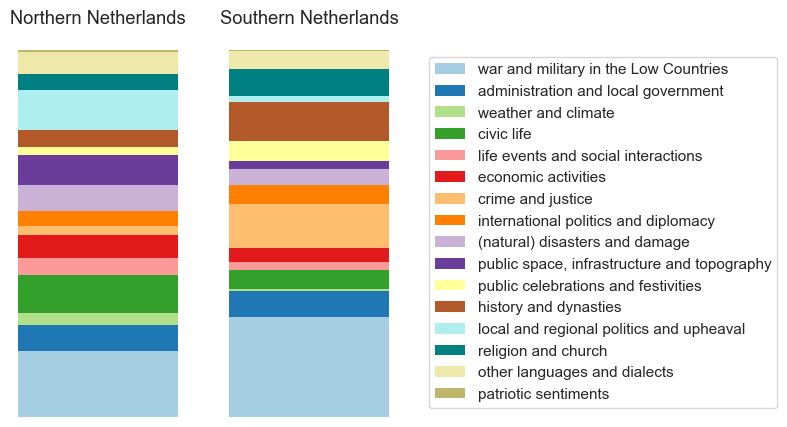

In [23]:
sns.set_style('white', {"patch.edgecolor": 'None'})

fig, axes = plt.subplots(1, 2, figsize=(5, 5), sharey=True) # 15, 23 # 15, 17
axes = axes.flatten()

# Create a dictionary to store legend handles
legend_handles = {}

for i, (index, row) in enumerate(grouped_nz.iterrows()):
    # Create a stacked bar plot
    bottom = np.zeros(len(row))
    for j, (category, value) in enumerate(row.iteritems()):
        rect = axes[i].bar(0, value, bottom=bottom, color=cmap(j))
        bottom += value
        
        # Store a patch handle with the corresponding column name
        if j not in legend_handles:
            legend_handles[j] = mpatches.Patch(color=cmap(j), label=category)
    
    # Set the plot title and rotate x-axis labels
    if index == 'n':
        axes[i].set_title('Northern Netherlands')
        #axes[i].set_title('north')
    else:
        axes[i].set_title('Southern Netherlands')
    axes[i].tick_params(axis='x', rotation=90)
    
    # Remove y-axis ticks
    axes[i].xaxis.set_ticks([])

    # Turn off axes and grid
    axes[i].axis('off')

# Create a legend using the stored patch handles
legend_patches = [legend_handles[j] for j in sorted(legend_handles)]
labels = cat_names_original
plt.legend(labels, bbox_to_anchor=(3.2, 0.48), loc ='right')
#plt.suptitle('Topic distribution in chronicles from the Northern and Southern Netherlands')
plt.savefig('../images/topic-distribution_nz.pdf', bbox_inches='tight')

### Average topic distribution in centre versus periphery

In [24]:
#topics_cp = authors_cat2.merge(result_cv[['call_nr_clean', 'cp']], left_on='call_nr_clean', right_on='call_nr_clean')
topics_cp = summed_counts2.merge(result_cv[['call_nr_clean', 'hub']], left_on='call_nr_clean', right_on='call_nr_clean')

In [25]:
grouped_cp = topics_cp.groupby('hub').mean()

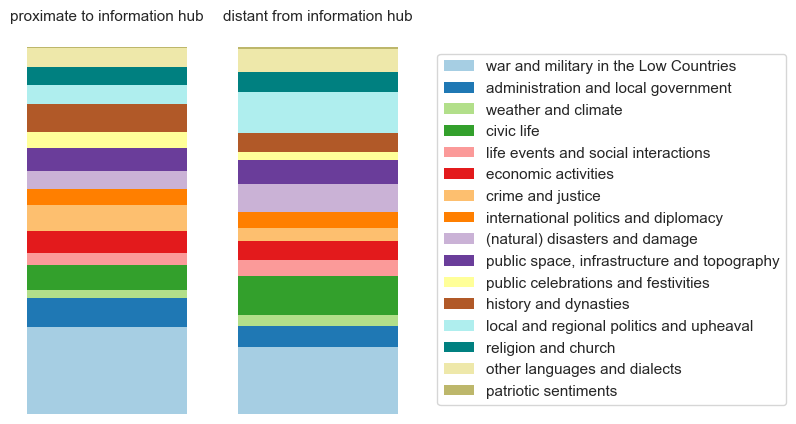

In [31]:
sns.set_style('white', {"patch.edgecolor": 'None'})

fig, axes = plt.subplots(1, 2, figsize=(5, 5), sharey=True) # 15, 23 # 15, 17
axes = axes.flatten()

# Create a dictionary to store legend handles
legend_handles = {}

for i, (index, row) in enumerate(grouped_cp.iterrows()):
    # Create a stacked bar plot
    bottom = np.zeros(len(row))
    for j, (category, value) in enumerate(row.iteritems()):
        rect = axes[i].bar(0, value, bottom=bottom, color=cmap(j))
        bottom += value
        
        # Store a patch handle with the corresponding column name
        if j not in legend_handles:
            legend_handles[j] = mpatches.Patch(color=cmap(j), label=category)
    
    # Set the plot title and rotate x-axis labels
    if index == 'i':
        axes[i].set_title('proximate to information hub', fontsize=11)
    else:
        axes[i].set_title('distant from information hub', fontsize=11)
    axes[i].tick_params(axis='x', rotation=90)
    
    # Remove y-axis ticks
    axes[i].xaxis.set_ticks([])

    # Turn off axes and grid
    axes[i].axis('off')

# Create a legend using the stored patch handles
legend_patches = [legend_handles[j] for j in sorted(legend_handles)]
labels = cat_names_original
plt.legend(labels, bbox_to_anchor=(3.2, 0.48), loc ='right')
#plt.suptitle('Topic distribution in chronicles from the centre and periphery')
plt.savefig('../images/topic-distribution_cp.pdf', bbox_inches='tight')

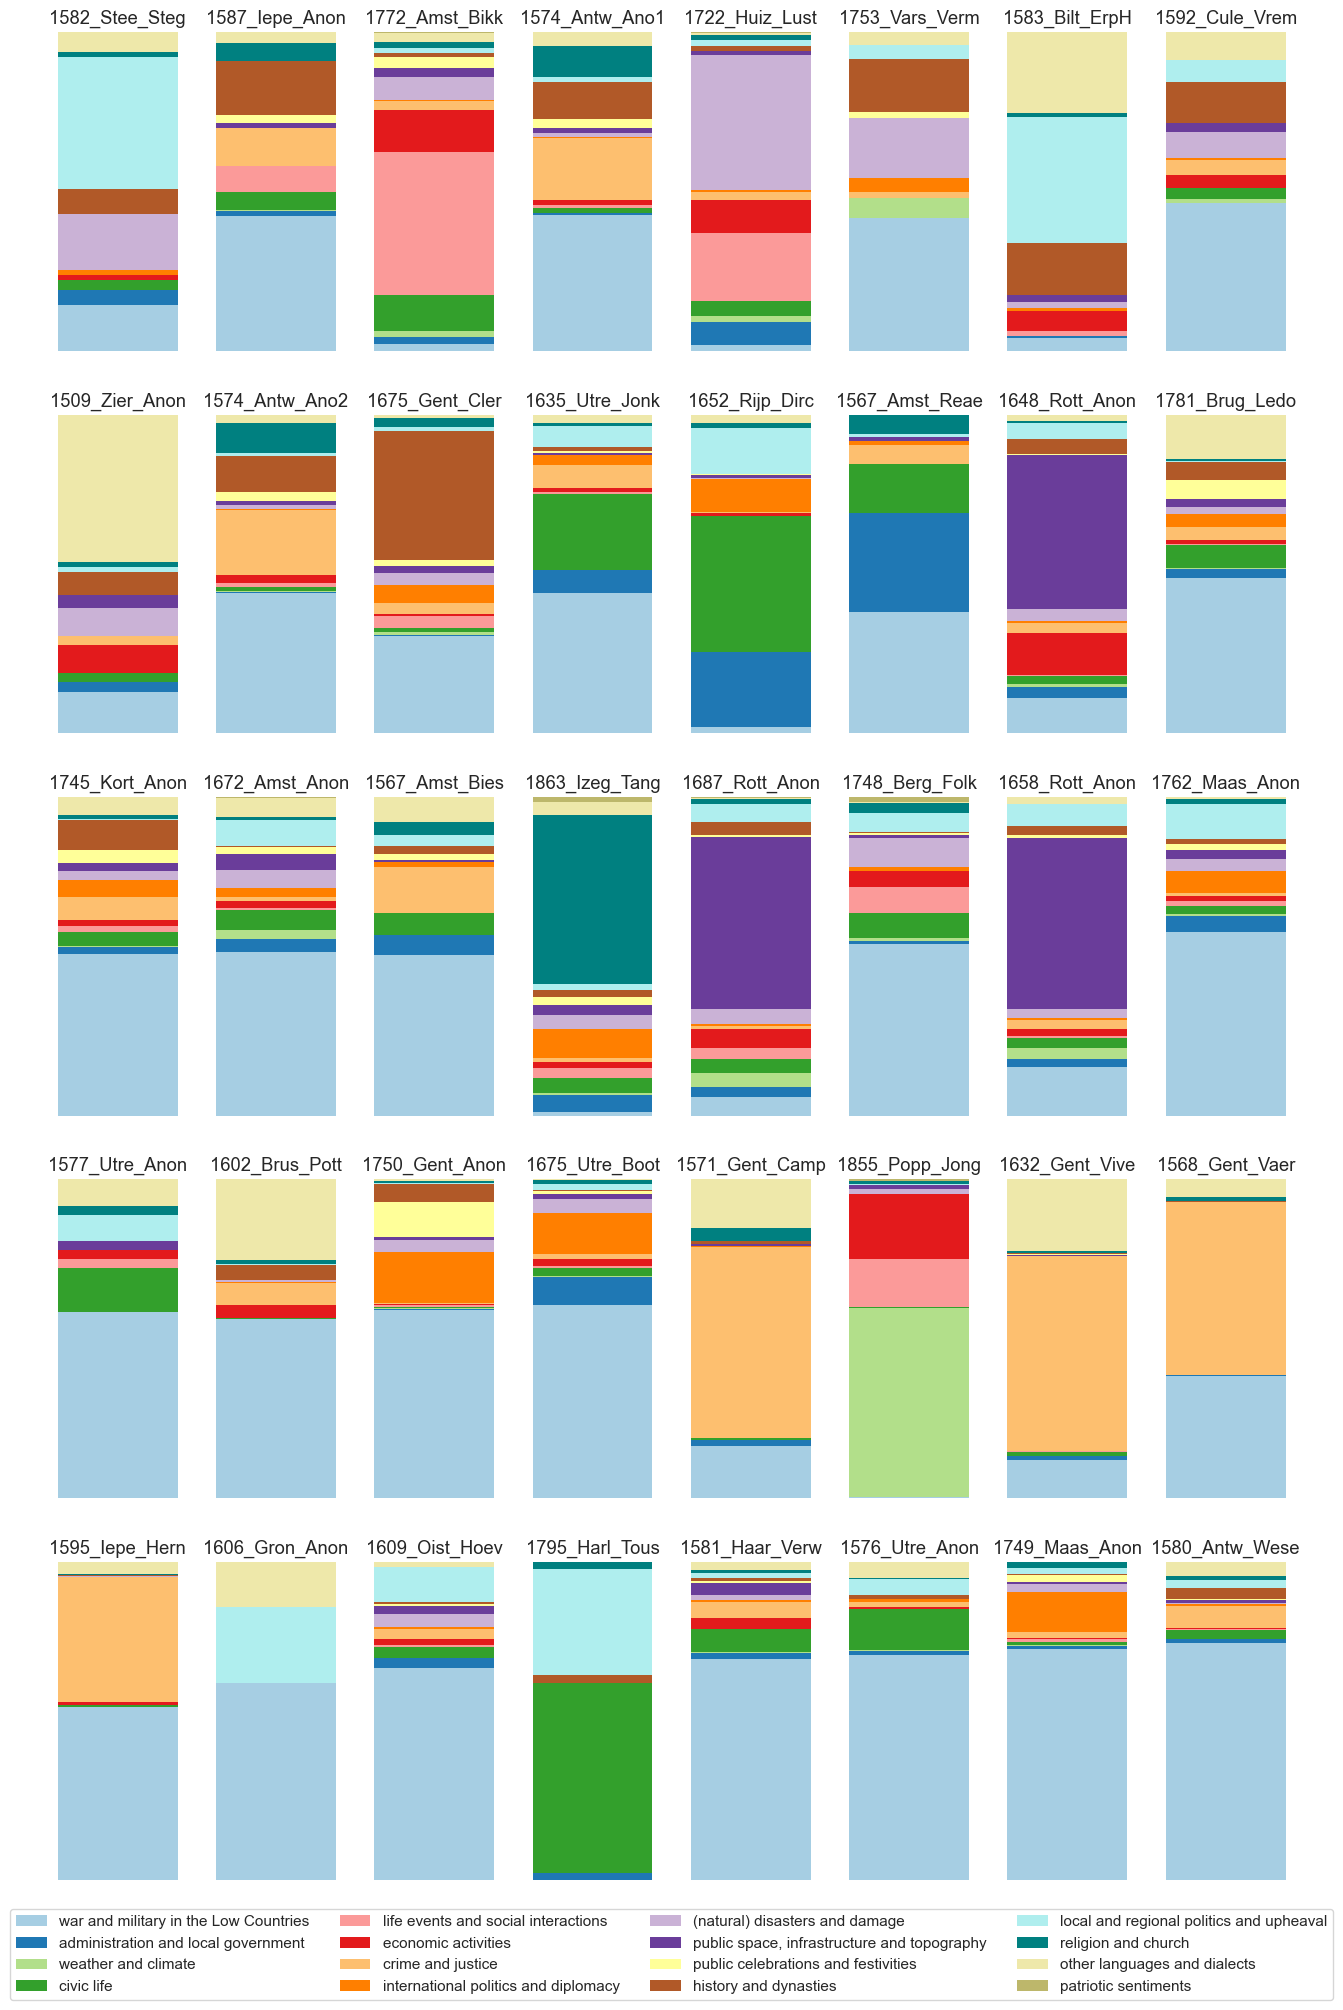

In [35]:
sns.set_style('white', {"patch.edgecolor": 'None'})

rows_to_plot = summed_counts2.iloc[80:120]

fig, axes = plt.subplots(5, 8, figsize=(16, 24), sharey=True) # voor de kleine: 1, 6 (figsize=(12,4)
axes = axes.flatten()                                          # voor de grote: 5, 8, figsize=(16, 24)

# Create a dictionary to store legend handles
legend_handles = {}

for i, (index, row) in enumerate(rows_to_plot.iterrows()):
    # Create a stacked bar plot
    bottom = np.zeros(len(row))
    for j, (category, value) in enumerate(row.iteritems()):
        rect = axes[i].bar(0, value, bottom=bottom, color=cmap(j))
        bottom += value
        
        # Store a patch handle with the corresponding column name
        if j not in legend_handles:
            legend_handles[j] = mpatches.Patch(color=cmap(j), label=category)
    
    # Set the plot title and rotate x-axis labels
    if index == '1750_Brus_Anon':
        index = '1750_Gent_Anon'
    axes[i].set_title(f'{index}')
    axes[i].tick_params(axis='x', rotation=90)
    
    # Remove y-axis ticks
    axes[i].xaxis.set_ticks([])

    # Turn off axes and grid
    axes[i].axis('off')

# Create a legend using the stored patch handles
legend_patches = [legend_handles[j] for j in sorted(legend_handles)]
labels = cat_names_original
plt.legend(labels, bbox_to_anchor=(-3.7, -0.4), loc ='lower center', ncol = 4)
# voor kleine, bbox_to_anchor=(-2.5, -0.4)
# voor grote, bbox_to_anchor=(-3.7, -0.4)

plt.savefig('../images/stacked_chron_80-120_new.pdf', bbox_inches='tight')


### Presentation size

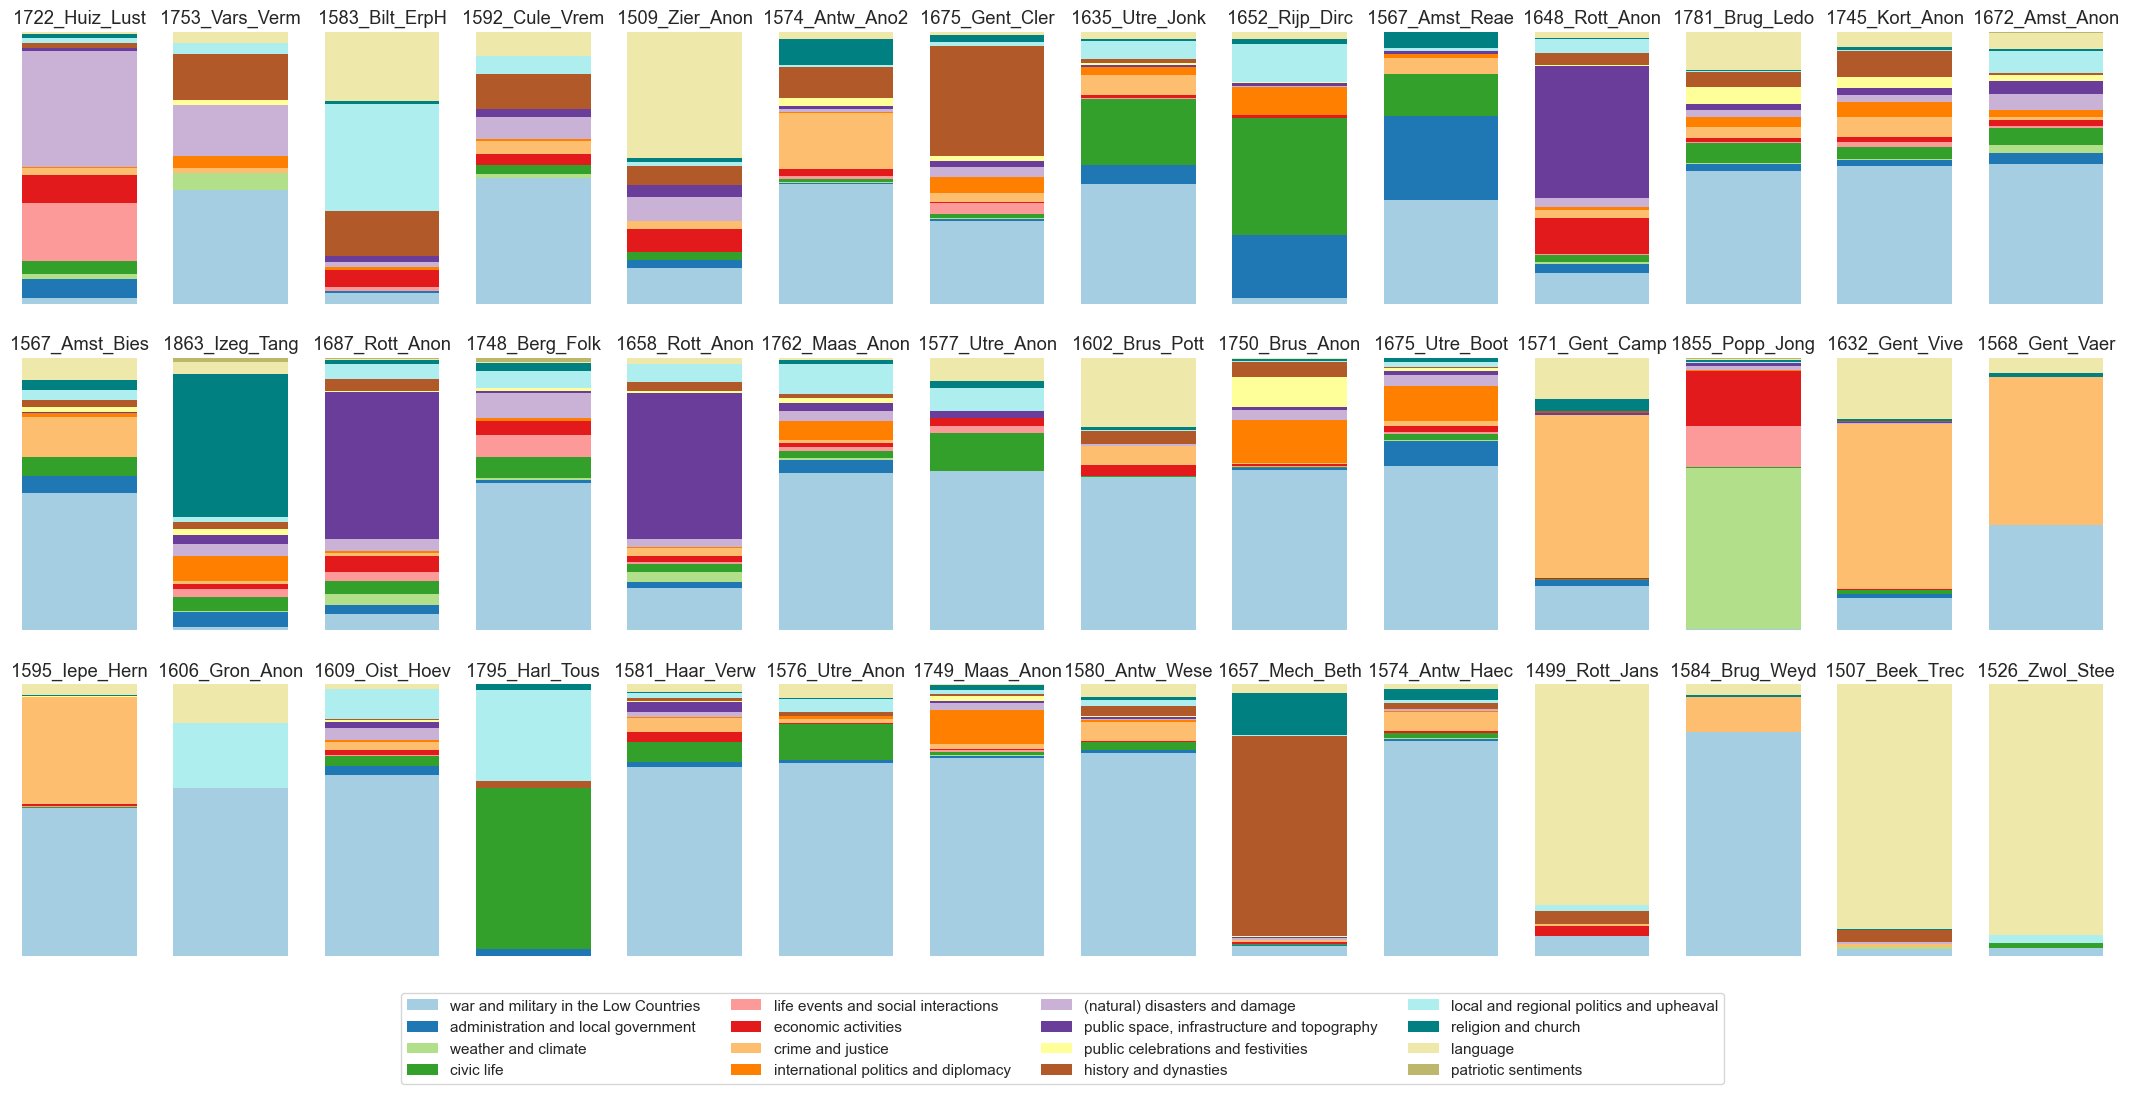

In [24]:
sns.set_style('white', {"patch.edgecolor": 'None'})

rows_to_plot = summed_counts2.iloc[84:126]

fig, axes = plt.subplots(3, 14, figsize=(27, 12), sharey=True) # 15, 23 # 15, 17
axes = axes.flatten()

# Create a dictionary to store legend handles
legend_handles = {}

for i, (index, row) in enumerate(rows_to_plot.iterrows()):
    # Create a stacked bar plot
    bottom = np.zeros(len(row))
    for j, (category, value) in enumerate(row.iteritems()):
        rect = axes[i].bar(0, value, bottom=bottom, color=cmap(j))
        bottom += value
        
        # Store a patch handle with the corresponding column name
        if j not in legend_handles:
            legend_handles[j] = mpatches.Patch(color=cmap(j), label=category)
    
    # Set the plot title and rotate x-axis labels
    axes[i].set_title(f'{index}')
    axes[i].tick_params(axis='x', rotation=90)
    
    # Remove y-axis ticks
    axes[i].xaxis.set_ticks([])

    # Turn off axes and grid
    axes[i].axis('off')

# Create a legend using the stored patch handles
legend_patches = [legend_handles[j] for j in sorted(legend_handles)]
labels = cat_names_original
plt.legend(labels, bbox_to_anchor=(-7.3, -0.5), loc ='lower center', ncol = 4)
plt.savefig('../images/stacked_chron_pres3.pdf', bbox_inches='tight')


### Chronicles ordered on described years

In [83]:
path = '/Users/alielassche/surfdrive/Shared/[Chronicles] team proceedings/Metadata kronieken/Chronicles_metadata.xlsx'
contemp = pd.read_excel(path, sheet_name = 'Chronicles')
contemp = contemp[['Call_Number', 'described_period_begin', 'described_period_end']]
contemp['call_nr_clean'] = contemp['Call_Number'].str[:14]
contemp = contemp.drop_duplicates(subset='call_nr_clean', keep='first')
contemp['described_period_begin'] = pd.to_numeric(contemp['described_period_begin'], errors='coerce')
contemp['described_period_begin'] = contemp['described_period_begin'].astype(int)
contemp['described_period_end'] = pd.to_numeric(contemp['described_period_end'], errors='coerce')
contemp['described_period_end'] = contemp['described_period_end'].astype(int)

In [84]:
contemp = contemp.set_index('call_nr_clean')
contemp['period'] = contemp['described_period_end'] - contemp['described_period_begin']
contemp = contemp.sort_values(by=['period'])
contemp['period'] = contemp['period'].replace({0: 1})

In [85]:
result_cv_period = result_cv.merge(contemp['period'], left_on='call_nr_clean', right_on = 'call_nr_clean')

In [86]:
result_cv_period.to_csv('../output/primitives_230807/result_cv_period_new.csv')

In [56]:
result_cv_period = pd.read_csv('../output/primitives_230807/result_cv_period.csv', sep=';', index_col=0)
result_cv_period.head()

,call_nr_clean,cv,year,nz,cp,period
0,1752_Zaan_Veen,0.529365,1752,n,p,12
1,1838_Hoor_Anon,0.783331,1838,n,p,208
2,1755_Hoor_Spru,0.921665,1755,n,p,125
3,1830_Tilb_Leli,0.966943,1830,n,p,56
4,1835_Gent_Call,0.994945,1835,z,c,55


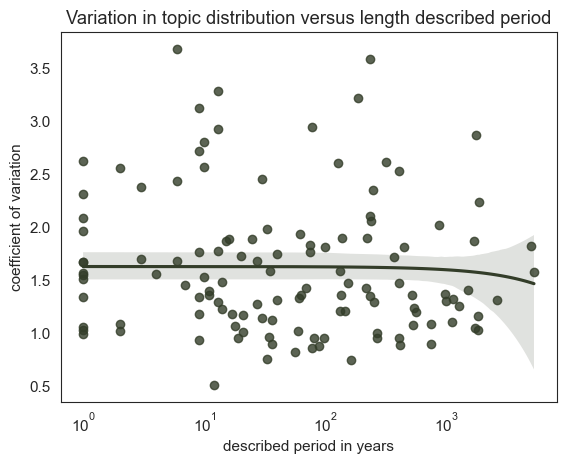

In [88]:
fig, axs = plt.subplots()

sns.regplot(x='period', y='cv', data=result_cv_period, marker='o', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
axs.set_xscale('log')
#axs.set_xlim([0, 1000])
axs.set_title('Variation in topic distribution versus length described period')
axs.set_ylabel('coefficient of variation')
axs.set_xlabel('described period in years')

fig.savefig('../images/distribution_period.pdf', bbox_inches='tight')